In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [28]:
# Границы отрезка
a = 0
b = np.pi / 2

In [29]:
# Граничные условия
alpha = np.array([1, 1])
beta = np.array([1, 0])
gamma = np.array([0, 1])

In [30]:
def exact_solution(x):
    return np.sin(x)

In [ ]:
def p(x):
    return 1

def q(x):
    return np.cos(x)

def r(x):
    return np.sin(x)

def f(x):
    return 1 - np.sin(x)

In [32]:
func = [p, q, r, f]

In [33]:
def runge_kutta_one_step(f, x, y, h, k1=None):
    ''' Шаг метода Рунге-Кутта 4-го порядка
        Функция принимает:
        f - диф. уравнение
        x - точку, в которой считаем новое приближение
        y - прошлое приближение
        h - длина шага 
        k1 - первый коэффициент (по умолчанию None)
        Функция возвращает новое приближение'''
    if k1 is None:
        k1 = f(x, y)
        
    k2 = f(x + h / 2, y + h / 2 * k1)
    k3 = f(x + h / 2, y + h / 2 * k2)
    k4 = f(x + h, y + h * k3)
    return y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [34]:
def runge_kutta(f, a, b, y0, h0, step='adaptive', eps=None, step_safe=False):
    ''' Метод Рунге-Кутта 4-го порядка
        Функция принимает:
        f - диф. уравнение
        a - левая граница отрезка
        b - правая граница отрезка
        y0 - начальное условие в точке a
        h0 - стартовый шаг
        eps - заданная точность 
        step - параметр
            adaptive - адаптивное изменение шага
            fixed - фиксированное значение шага
        step_safe - параметр
            True - сохраняем шаг
            False - не сохраняем шаг
        Функция возвращает численное решение на заданном отрезке'''
        
    x = a
    y = y0
    h = h0
    y_h1 = None
    y_2h = None
    # Список для хранения длин шага
    if step_safe == True:
        h_list = [h]

    # Список кортежей для хранения решения
    solution = [(x, y)]

    while x < b:
        # Условие для того, чтобы избежать выхода за пределы отрезка
        if x + 2 * h > b:
            h = (b - x) / 2
            
        # Делаем два шага метода по h
        if y_h1 is None:
            k1h = f(x, y)
            y_h1 = runge_kutta_one_step(f, x, y, h, k1=k1h)
            y_h2 = runge_kutta_one_step(f, x + h, y_h1, h)
        # Делаем один шаг 2h
        if y_2h is None:
            y_2h = runge_kutta_one_step(f, x, y, 2 * h, k1=k1h)

        # Вычисляем ошибку
        error = np.linalg.norm((y_2h - y_h2) / 15)
        
        # Применяем поправку Ричардсона
        y_new = y_h2 + (y_h2 - y_2h) / 15

        if step == 'adaptive':
            # Провеяем достижение заданной точности
            if error <= eps:  
                y_h1 = None
                y_2h = None
                x += 2 * h
                y = y_new
                solution.append((x, y))
                # Если ошибка намного меньше заданной точности, то увеличиваем шаг
                if error < eps / 32:
                    h *= 2
            # Если точность не достигнута, уменьшем шаг
            else: 
                h /= 2
                y_2h = y_h2 
                y_h1 = None
        
            if step_safe == True:
                h_list.append(h)

        elif step == 'fixed':
            y_h1 = None
            y_2h = None
            x += 2 * h
            y = y_new
            solution.append((x, y))
       
    if step_safe == True:
        return solution, np.array(h_list)
    else:
        return solution

In [35]:
def superposition(func, a, b, alpha, beta, gamma, h0, eps=None, step='adaptive', step_safe=False):
    '''Метод суперпозиции (сведение к двум задачам Коши)
        Функция принимает:
        func - список функций-частей ОДУ p, q, r, f
        a - левая граница отрезка
        b - правая граница отрезка
        alpha - список коэффициентов alpha
        beta - список коэффициентов beta
        gamma - список коэффициентов правой части ГУ
        h0 - стартовый шаг
        eps - заданная точность
        step - параметр
            adaptive - адаптивное изменение шага
            fixed - фиксированное значение шага
        step_safe - параметр
            True - сохраняем шаг
            False - не сохраняем шаг
        Функция возвращает решение ОДУ, удовлетворяющее заданным ГУ.
        '''
    p, q, r, f = func

    # Неоднородное уравнение
    def system_inhomogeneous(x, y):
        return np.array([y[1], (f(x) - q(x) * y[1] - r(x) * y[0]) / p(x)])
    
    # Однородное уравнение
    def system_homogeneous(x, y):
        return np.array([y[1], (-q(x) * y[1] - r(x) * y[0]) / p(x)])

    # Решаем неоднородной задачи с произвольными условиями
    v0 = np.array([0.0, 1.0])
    if step_safe == True:
        sol_v, h_list = runge_kutta(system_inhomogeneous, a, b, v0, h0, step=step, eps=eps, step_safe=True)
    else:
        sol_v = runge_kutta(system_inhomogeneous, a, b, v0, h0, step=step, eps=eps)
    x_v = np.array([point[0] for point in sol_v])
    v = np.array([point[1][0] for point in sol_v])
    dv = np.array([point[1][1] for point in sol_v])

    # Решение однородной задачи с заданными начальными условиями
    u0 = np.array([alpha[1], -alpha[0] / v[-1]])
    sol_u = runge_kutta(system_homogeneous, a, b, u0, h0, step=step, eps=eps)
    x_u = np.array([point[0] for point in sol_u])
    u = np.array([point[1][0] for point in sol_u])
    du = np.array([point[1][1] for point in sol_u])

    # Сетки могут не совпадать! Нужна интерполяция
    u_interp = np.interp(x_v, x_u, u)      # Интерполяция u(x) -> x_v
    du_interp = np.interp(x_v, x_u, du)    # Интерполяция u'(x) -> x_v
    u, du = u_interp, du_interp

    C = (gamma[1] - beta[0] * v[-1] - beta[1] * dv[-1]) / (beta[0] * u[-1] + beta[1] * du[-1]) 
    if step_safe == True:
        return x_v, h_list
    else:
        return x_v, v + C * u

In [36]:
h1 = 0.2
h2 = 0.5

x_h1, y_h1 = superposition(func, a, b, alpha, beta, gamma, h1, step='fixed' )
x_h2, y_h2 = superposition(func, a, b, alpha, beta, gamma, h2, step='fixed' )


test_grid = np.linspace(a, b, 1000)

error_h1 = abs(y_h1 - exact_solution(x_h1))
error_h2 = abs(y_h2 - exact_solution(x_h2))

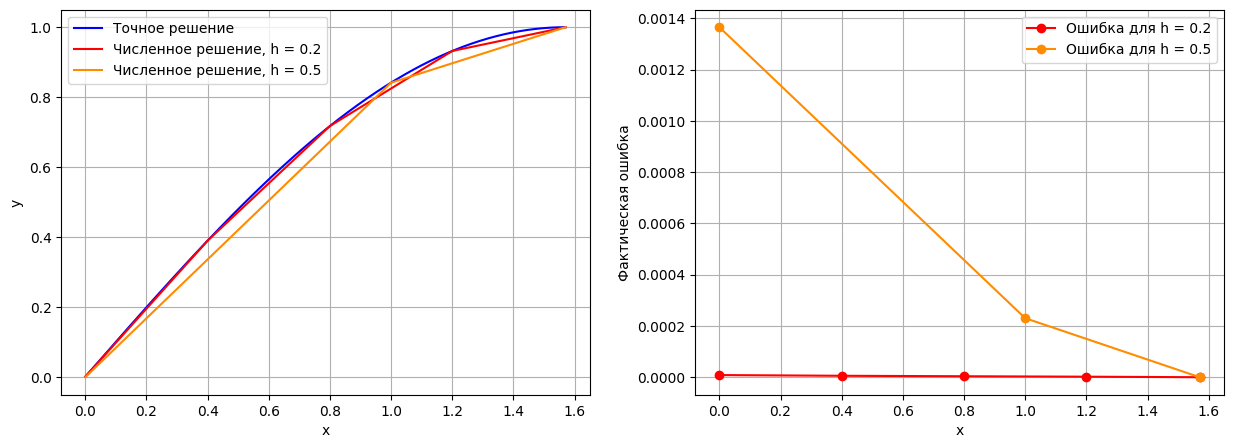

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(test_grid, exact_solution(test_grid), color='blue', label='Точное решение')
ax[0].plot(x_h1, y_h1, color = 'red', label=f'Численное решение, h = {h1}')
ax[0].plot(x_h2, y_h2, color = 'darkorange', label=f'Численное решение, h = {h2}')
#ax[0].set_title('Графики численных решений для фиксированных значений шага на отрезке')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].plot(x_h1, error_h1, color='red', label=f'Ошибка для h = {h1}', marker='o')
ax[1].plot(x_h2, error_h2, color='darkorange', label=f'Ошибка для h = {h2}', marker='o')
#ax[1].set_title('Графики ошибок на отрезке для решений')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Фактическая ошибка')
for i in range(2):
    ax[i].grid(True)
    ax[i].legend()

In [38]:
# Зависимость фактической ошибки от заданной точности

eps_list = [0.1 ** k for k in range(1, 12)]
errors_from_eps = []
for i in eps_list:
    x, y = superposition(func, a, b, alpha, beta, gamma, 1e-3, eps=i)
    error = np.linalg.norm(y - exact_solution(x))
    errors_from_eps.append(error)

In [39]:
x_list, h_list = superposition(func, a, b, alpha, beta, gamma, 1e-3, eps=1e-2, step_safe=True)

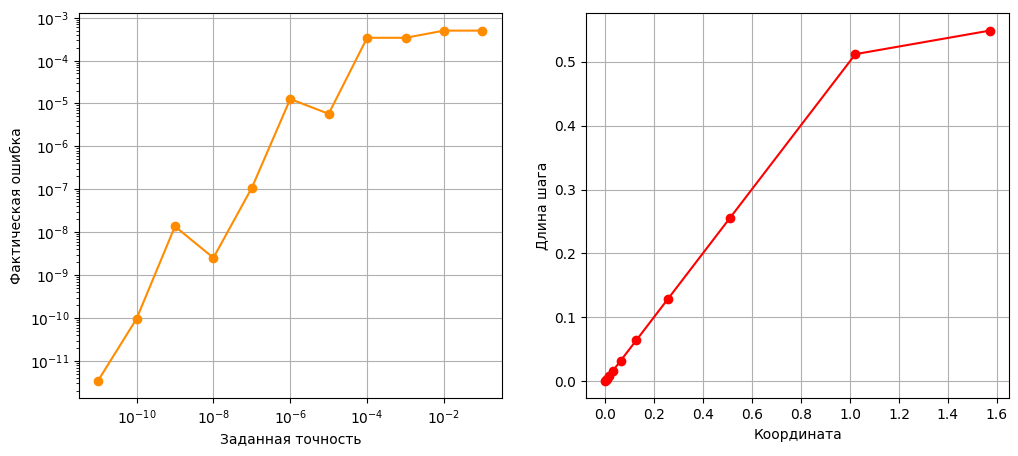

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].loglog(eps_list, errors_from_eps, color='darkorange', marker="o")
#ax[0].set_title('Зависимость фактической ошибки от заданной точности')
ax[0].set_ylabel('Фактическая ошибка')
ax[0].set_xlabel('Заданная точность')

ax[1].plot(x_list, h_list, color='red', marker='o')
#ax[1].set_title('Зависимость длины шага от координаты')
ax[1].set_ylabel('Длина шага')
ax[1].set_xlabel('Координата')

for i in range(2):
    ax[i].grid(True)

In [41]:
# Зависимость фактической ошибки от фиксированного шага интегрирования

h_list = [i for i in np.linspace(0.05, 0.95, 10)]
errors_from_fix_h = []
for i in h_list:
    x, y = superposition(func, a, b, alpha, beta, gamma, i, step='fixed')
    error = np.linalg.norm(np.abs(y - exact_solution(x))) 
    errors_from_fix_h.append(error)

Text(0, 0.5, 'Фактическая ошибка')

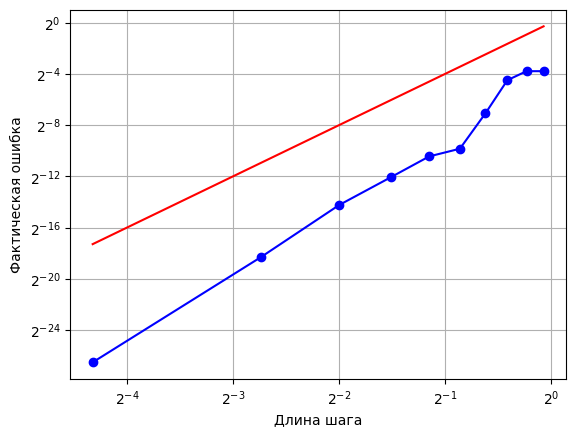

In [42]:
plt.loglog(h_list, errors_from_fix_h, base=2, color='blue', marker='o', label='Фактическая ошибка')
plt.loglog(h_list, np.pow(h_list, 4), base=2, color='red', label='Биссектриса')
plt.grid(True)
#plt.title('Зависимость фактической ошибки от факсированной длины шага')
plt.xlabel('Длина шага')
plt.ylabel('Фактическая ошибка')

In [43]:
# Определяем порядок метода
log_h = np.log2(h_list)
log_error = np.log2(errors_from_fix_h)
slope, _, _, _, _ = linregress(log_h, log_error)
slope

np.float64(5.419126882656547)

ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ

In [44]:
def relative_error(true_values, num_values):
    return np.linalg.norm(true_values - num_values) / np.linalg.norm(true_values)

def create_noise(data, max_noise_persent):
    noise = np.random.uniform(-max_noise_persent/100, max_noise_persent/100)
    return data * (1 + noise)

In [45]:
noise_levels = [1, 2, 3, 4, 5]
num_experiments = 20

In [46]:
results = {level: [] for level in noise_levels}

for level in noise_levels:
    for _ in range(num_experiments):
        noisy_gamma = create_noise(gamma, level)
        num_x, num_y = superposition(func, a, b, alpha, beta, noisy_gamma, 1e-1, eps = 1e-1)
        true_values = exact_solution(num_x)
        error = 100 * relative_error(true_values, num_y)
        results[level].append(error)

Text(0, 0.5, 'Ошибка (%)')

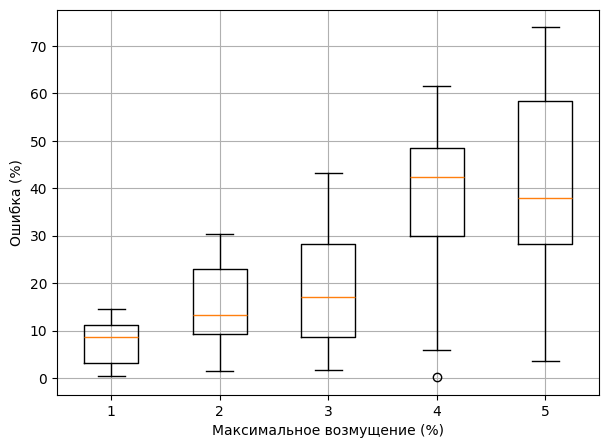

In [47]:
plt.figure(figsize=(7, 5))

plt.boxplot([results[level] for level in noise_levels])
plt.grid('True')
plt.xlabel('Максимальное возмущение (%)')
plt.ylabel('Ошибка (%)')
#plt.title('Зависимость относительной ошибки решения ОДУ от возмущения начального условия')